In [1]:
# ✅ 셀 1: 패키지 및 설정
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 크롬 설정
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

service = Service('C:/Users/User/.wdm/drivers/chromedriver/win64/136.0.7103.94/chromedriver-win32/chromedriver.exe')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 중복 방지 경로 생성 함수
def unique_path(path):
    if not os.path.exists(path):
        return path
    base, ext = os.path.splitext(path)
    i = 1
    while os.path.exists(f"{base}({i}){ext}"):
        i += 1
    return f"{base}({i}){ext}"

# 저장 경로 설정
today_str = datetime.today().strftime('%Y-%m-%d')
folder_path = unique_path(os.path.join('data', today_str))
os.makedirs(folder_path, exist_ok=True)
merged_file_path = unique_path(os.path.join(folder_path, f"{today_str}_전체_리뷰통합.csv"))

# 감성 키워드
pos_words = ['좋다','재밌다','감동','최고','웃기다','재밌었어요','흥미진진','꿀잼','완전 재밌음','감명', '귀엽', '참 잘', '미쳤다', '따뜻',
            '울컥', '신남', '신나고', '정말 좋', '잼있', '현실감 있', '너무 좋', '퀄리티 미쳤', '미쳤어요', '미침', '좋아하네요', '좋아요', '좋음',
            '예뻐', '제일 잘', '또 봐야지', '힐링', '놀람', '추천', '케미', '재밌', '최고', '여운', '좋았습니다', '재밌어요', '좋았어요',
            '응원', '신선', '제일 괜찮', '다음 기대', '잘 표현', '또 봐야', '잘 봤', '기대되', '즐거운']
             
neg_words = ['지루', '별로', '최악', '실망', '노잼', '지루했어요', '망작', '형편없다', '재미없음','진부', '좀.', '개빡', '볼만', '아닌듯', '불편',
             '딱히', '그닥', '비추', '흥미없', '재미없어요', '재미없다', '쓰레기', '아깝다', '최악', '유발', '졸림', '애매']

def analyze_sentiment(text):
    text = str(text).lower()
    pos = sum(w in text for w in pos_words)
    neg = sum(w in text for w in neg_words)
    if pos > neg:
        return '긍정'
    elif neg > pos:
        return '부정'
    else:
        return '중립'

In [2]:
# ✅ 셀 2: 리뷰 수집 함수 정의
def get_all_reviews(url):
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get(url)
    time.sleep(1)

    writers, reviews, dates = [], [], []

    while True:
        try:
            writers += [w.text for w in driver.find_elements('class name', 'writer-name')]
            reviews += [r.text for r in driver.find_elements('class name', 'box-comment')]
            dates += [d.text for d in driver.find_elements('class name', 'day')]

            next_button = driver.find_element('class name', 'btn-paging.next')
            next_button.click()
            time.sleep(0.5)
        except:
            break

    driver.quit()

    df = pd.DataFrame({'날짜': dates, '작성자': writers, '리뷰내용': reviews})
    df['감성'] = df['리뷰내용'].apply(analyze_sentiment)
    return df


In [3]:
# ✅ 셀 3: 메인 크롤링 및 저장 루프
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get('http://www.cgv.co.kr/movies/')
time.sleep(1)

# 더보기 버튼 반복 클릭
while True:
    try:
        more = driver.find_element('class name', 'btn-more-fontbold')
        driver.execute_script("arguments[0].click();", more)
        time.sleep(1)
    except:
        break

# 영화 요소 수집
movie_chart = driver.find_element('class name', 'sect-movie-chart')
contents = movie_chart.find_elements('class name', 'box-contents')

all_reviews = []
summary_data = []

for content in contents:
    try:
        title = content.find_element('class name', 'title').text
        url = content.find_element('tag name', 'a').get_attribute('href')

        print(f"\n🎬 수집 중: {title}")
        df = get_all_reviews(url)
        if df.empty:
            print("(리뷰 없음) 건너뜀")
            continue

        safe_title = ''.join(c for c in title if c.isalnum() or c.isspace()).strip()
        csv_path = unique_path(os.path.join(folder_path, f"{safe_title}_리뷰.csv"))
        df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {csv_path} ({len(df)}개)")

        df['영화제목'] = title
        all_reviews.append(df)

        # 감성 시각화 - 파이
        counts = df['감성'].value_counts()
        counts.plot(kind='pie', autopct='%.1f%%', ylabel='', title=f'{title} 리뷰 감성 분포')
        plt.savefig(unique_path(os.path.join(folder_path, f"{safe_title}_감성분포.png")))
        plt.clf()

        # 요약용 정보 저장
        summary_data.append({
            '영화제목': title,
            '리뷰수': len(df),
            '긍정': (df['감성'] == '긍정').sum(),
            '부정': (df['감성'] == '부정').sum(),
            '중립': (df['감성'] == '중립').sum()
        })

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        continue


🎬 수집 중: 28년 후
✅ 저장 완료: data\2025-06-25(1)\28년 후_리뷰.csv (594개)

🎬 수집 중: 드래곤 길들이기
✅ 저장 완료: data\2025-06-25(1)\드래곤 길들이기_리뷰.csv (1218개)

🎬 수집 중: 퀴어
✅ 저장 완료: data\2025-06-25(1)\퀴어_리뷰.csv (162개)

🎬 수집 중: 엘리오
✅ 저장 완료: data\2025-06-25(1)\엘리오_리뷰.csv (498개)

🎬 수집 중: 하이파이브
✅ 저장 완료: data\2025-06-25(1)\하이파이브_리뷰.csv (1620개)

🎬 수집 중: 해피엔드
✅ 저장 완료: data\2025-06-25(1)\해피엔드_리뷰.csv (306개)

🎬 수집 중: 인생은 아름다워
✅ 저장 완료: data\2025-06-25(1)\인생은 아름다워_리뷰.csv (774개)

🎬 수집 중: 미션 임파서블: 파이널 레코닝
✅ 저장 완료: data\2025-06-25(1)\미션 임파서블 파이널 레코닝_리뷰.csv (2412개)

🎬 수집 중: 신명
✅ 저장 완료: data\2025-06-25(1)\신명_리뷰.csv (600개)

🎬 수집 중: 인피니트 15주년 콘서트 리미티드 에디션 더 무비
✅ 저장 완료: data\2025-06-25(1)\인피니트 15주년 콘서트 리미티드 에디션 더 무비_리뷰.csv (60개)

🎬 수집 중: 하보우만의 약속
✅ 저장 완료: data\2025-06-25(1)\하보우만의 약속_리뷰.csv (18개)

🎬 수집 중: 씨너스: 죄인들
✅ 저장 완료: data\2025-06-25(1)\씨너스 죄인들_리뷰.csv (384개)

🎬 수집 중: 차은우 브이알 콘서트 : 메모리즈 (CHA EUN-WOO VR CONCERT : MEMORIES)
✅ 저장 완료: data\2025-06-25(1)\차은우 브이알 콘서트  메모리즈 CHA EUNWOO VR CONCERT  MEMORIES_리뷰.csv (6개)

🎬 수집 중: 브링 허 백
✅ 저

<Figure size 640x480 with 0 Axes>


📦 전체 통합 리뷰 저장 완료: data\2025-06-25(1)\2025-06-25_전체_리뷰통합.csv (9516개)


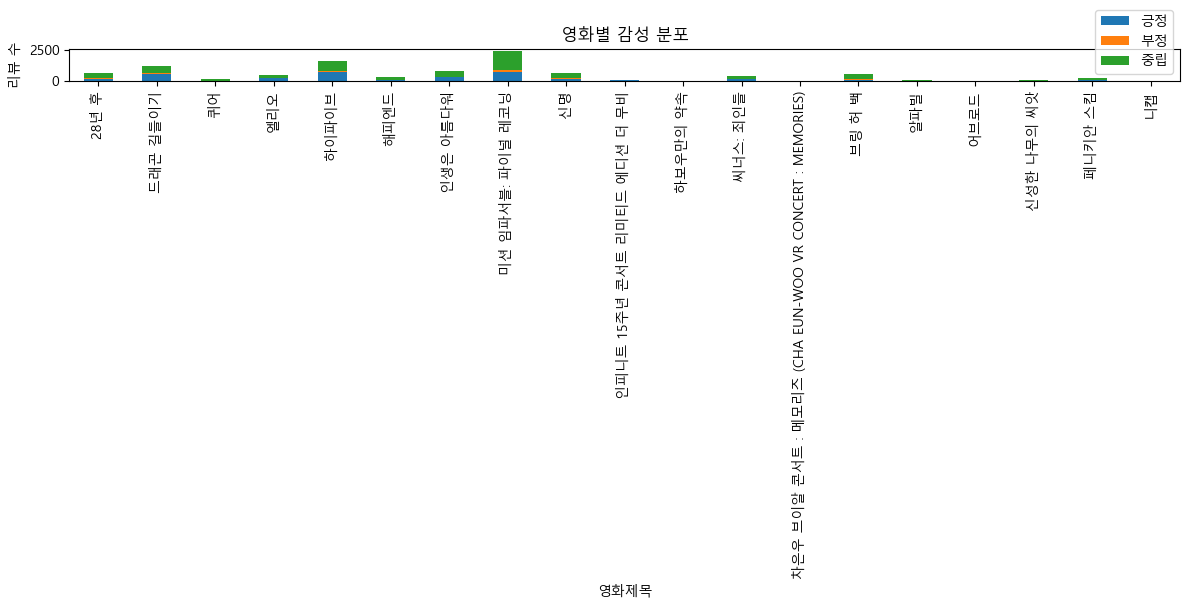

In [6]:
# ✅ 셀 4: 전체 리뷰 통합 저장 및 막대그래프
if all_reviews:
    merged_df = pd.concat(all_reviews, ignore_index=True)
    merged_df.to_csv(merged_file_path, index=False, encoding='utf-8-sig')
    print(f"\n📦 전체 통합 리뷰 저장 완료: {merged_file_path} ({len(merged_df)}개)")

    # 요약 데이터프레임 생성 및 시각화
    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index('영화제목')[['긍정', '부정', '중립']].plot(kind='bar', stacked=True, figsize=(12,6), title='영화별 감성 분포')
    plt.ylabel('리뷰 수')
    plt.tight_layout()
    plt.savefig(unique_path(os.path.join(folder_path, "영화별_감성_막대그래프.png")))
    plt.show()
else:
    print("❌ 수집된 리뷰가 없습니다.")

In [11]:
import os
import pandas as pd
from glob import glob

# 모든 날짜 폴더 경로
base_path = r'D:\_DeepNLP25\_DEEPNLP\data'
folders = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

all_dfs = []

for folder in folders:
    # 리뷰 CSV 파일만 찾기
    csv_files = glob(os.path.join(folder, '*_리뷰.csv'))
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df['영화제목'] = os.path.basename(file).replace('_리뷰.csv', '')
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ 오류: {file} - {e}")

# 전체 리뷰 데이터 통합
merged_df = pd.concat(all_dfs, ignore_index=True)

# 컬럼 확인
print(merged_df.columns)

# 앞부분 확인
merged_df.head()

Index(['날짜', '작성자', '리뷰내용', '영화제목', '감성'], dtype='object')


,날짜,작성자,리뷰내용,영화제목,감성
0,2025.05.20,osasuna,너무나도 재미있게 잘 봤으며 주위사람들에게 적극 추천하고자 합니다,A MINECRAFT MOVIE 마인크래프트 무비,NaN
1,2025.05.20,sjw0818,요오요오용암 치치치치킨,A MINECRAFT MOVIE 마인크래프트 무비,NaN
2,2025.05.20,ky**ang,초등학생 자녀랑 보기에 너무 좋은 영화였어요ㅎㅎ 웃긴 장면들도 많았고 게임느낌을 잘...,A MINECRAFT MOVIE 마인크래프트 무비,NaN
3,2025.05.20,무지단장,재밌게 잘 봤습니다~^^,A MINECRAFT MOVIE 마인크래프트 무비,NaN
4,2025.05.20,명탐정호난,생각보다는 재미가 좀 덜 했습니다만 웃음포인트는 군데군데 있었어요,A MINECRAFT MOVIE 마인크래프트 무비,NaN


In [13]:
# 감성 컬럼이 없다면 새로 만들어도 됨 (예: '감성' 컬럼이 없는 경우)
if '감성' not in merged_df.columns:
    merged_df['감성'] = '중립'  # 또는 임시값

# 저장
output_path = os.path.join(base_path, '모든영화리뷰_통합본.csv')
merged_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 통합 저장 완료: {output_path} (총 {len(merged_df)}개 리뷰)")

✅ 통합 저장 완료: D:\_DeepNLP25\_DEEPNLP\data\모든영화리뷰_통합본.csv (총 39426개 리뷰)


In [21]:
import sys
!{sys.executable} -m pip install wordcloud

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud
from collections import Counter

# 1. CSV 파일 읽기 (업로드된 경로)
csv_path = 'D:\_DeepNLP25\_DEEPNLP\data\모든영화리뷰_통합본.csv'
df = pd.read_csv(csv_path)

# 2. 감성 분포 원형 그래프
plt.figure(figsize=(6, 6))
df['감성'].value_counts().plot(
    kind='pie',
    autopct='%.1f%%',
    startangle=90,
    colors=['green', 'red', 'gray']
)
plt.title('감성 분포 원형 그래프')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, '감성_원형그래프.png'))
plt.close()

# 3. 감성 분포 막대 그래프
plt.figure(figsize=(8, 5))
df['감성'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('감성 분포 막대 그래프')
plt.xlabel('감성')
plt.ylabel('리뷰 수')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, '감성_막대그래프.png'))
plt.close()

# 4. 워드 클라우드 생성
text = ' '.join(df['리뷰내용'].astype(str))
words = text.split()
word_counts = Counter(words)

wordcloud = WordCloud(
    font_path=None,
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('리뷰 워드 클라우드')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, '워드클라우드.png'))
plt.close()